In [1]:
import pandas as pd
import numpy as np
import re

In [137]:
laptops = pd.read_csv('laptops.csv', encoding = "ISO-8859-1")

In [3]:
companies = laptops['Company'].unique()
products = laptops['Product'].unique()
searches = laptops['Company'] + ' ' + laptops['Product']
searches = searches.str.replace(' ', '%20')
searches = searches.unique()
len(searches)

620

In [71]:
#Import the requests function and use it to download the page
import requests

#Import BeautifulSoup and use it on the downloaded page
from bs4 import BeautifulSoup

In [138]:
query = "https://www.cnet.com/search?query="

#the loops
scrapes = []
queries = []

for i in range(len(searches)):
  review = []
  
  try:
      page = requests.get(query+searches[i])
      soup = BeautifulSoup(page.content, 'html.parser')
      review = soup.find_all('p', class_='dek')
      reviews = [r.get_text() for r in review]
      scrapes.append(reviews[0])
      queries.append(searches[i])
  except:
      pass

scrapes[0:20]

["The classic MacBook Air gets the biggest makeover in Apple's new M1 chip Mac lineup, going fanless and adding hours battery life.",
 "The classic MacBook Air gets the biggest makeover in Apple's new M1 chip Mac lineup, going fanless and adding hours battery life.",
 "A good mesh router will spread fast, reliable internet speeds throughout your entire home. These are the best we've tested.",
 'An inexpensive Windows laptop for undemanding tasks, the Acer Aspire 1 offers just enough to get the basics done.',
 'With an OLED main display and a supplemental monitor as well as powerful components, the Asus ZenBook Pro is a strong contender as a photo-editing champ.',
 'The Acer Swift 3 is a budget laptop with an impressive all-metal design, but it skimps on some features you might find important.',
 "The Dell Inspiron 27 7000 is a great looking update to the previous 2017 model. It's still a reasonable price for a student on a budget.",
 'Move over iPhone SE. This is the small iPhone peopl

In [ ]:
#Should we want to review any of the HTML for the pages that we scraped...
# (this is what we used to find the object 'p' and class 'dek' for the reviews)

#print(soup.prettify())

In [143]:
#Cleaning the results!

#Recombining the queries and scrapes from the for loop above
dict = {'Searches':queries,'Reviews':scrapes}

#Converting this recombination into a dataframe
df_reviews = pd.DataFrame(dict)

#Splitting the "searches" back into seperate Company and Product columns
df_reviews[['Company', 'Product']] = df_reviews['Searches'].str.split('%20', 1, expand=True)

#Now converting the %20 back into spaces in the Product column
df_reviews['Product'] = df_reviews['Product'].str.replace('%20', ' ')

#Dropping the searches column as we no longer need it
df_reviews = df_reviews.drop('Searches', 1)

#Re-ordering the dataframe
df_reviews = df_reviews[["Company", "Product", "Reviews"]]

,Searches,Reviews
0,Apple%20MacBook%20Pro,The classic MacBook Air gets the biggest makeo...
1,Apple%20Macbook%20Air,The classic MacBook Air gets the biggest makeo...
2,HP%20250%20G6,"A good mesh router will spread fast, reliable ..."
3,Acer%20Aspire%203,An inexpensive Windows laptop for undemanding ...
4,Asus%20ZenBook%20UX430UN,With an OLED main display and a supplemental m...


In [172]:
#Dropping duplicate reviews

#Duplicate reviews were the result of the duplication in our sample
#For instance, our sample contains many variations of the same laptop, e.g.
#  Lenovo V310-15ISK (i5-6200U/4GB/1TB/FHD/No
#  Lenovo V330-15IKB (i5-8250U/4GB/500GB/FHD/W10)
#  Lenovo V310-15ISK (i5-7200U/8GB/1TB
#  Lenovo V310-15IKB (i5-7200U/4GB/1TB/No

#CNET reviewed all of these laptops at once, hence there only being 1 unique review for these 4 searches

nodups = df_reviews.drop_duplicates(subset=['Reviews'])
len(nodups)

,Company,Product,Reviews
0,Apple,MacBook Pro,The classic MacBook Air gets the biggest makeo...
1,Apple,Macbook Air,The classic MacBook Air gets the biggest makeo...
2,HP,250 G6,"A good mesh router will spread fast, reliable ..."
3,Acer,Aspire 3,An inexpensive Windows laptop for undemanding ...
4,Asus,ZenBook UX430UN,With an OLED main display and a supplemental m...


In [90]:
#When we reviewed the data, we found one review for a car that made it in there that should not have
remove = nodups.loc[(nodups['Product'] == '255 G6')]
remove

,Company,Product,Reviews
11,HP,255 G6,The midsize SUV is a popular choice with buyer...


In [91]:
nodups = nodups.drop(labels=[11], axis=0)
len(nodups)

141

In [182]:
#We're down to just 141 reviews, but we promise this will still be interesting!

#We still have reviews from all 19 companies of laptops
len(nodups['Company'].unique())

19

In [197]:
#And as you can see, most of the duplicate reviews came from the most common companies
nodupcount = pd.DataFrame(nodups['Company'].value_counts())
nodupcount.columns = ['After_De-Duplication']

reviewcount = pd.DataFrame(df_reviews['Company'].value_counts())
reviewcount.columns = ['Before_De-Duplication']

counts = pd.concat([reviewcount, nodupcount], axis=1, join='inner')
counts

,Before_De-Duplication,After_De-Duplication
Lenovo,138,16
Asus,127,21
HP,121,28
Dell,62,10
Acer,55,19
MSI,38,13
Toshiba,36,14
Mediacom,5,4
Apple,4,2
Vero,4,2


In [1]:
#Picking up where we left off
import pandas as pd
import re
nodups = pd.read_csv('nodups.csv')
nodups = nodups.drop('Unnamed: 0', 1)
nodups.head()

,Company,Product,Reviews
0,Apple,MacBook Pro,The classic MacBook Air gets the biggest makeo...
1,HP,250 G6,"A good mesh router will spread fast, reliable ..."
2,Acer,Aspire 3,An inexpensive Windows laptop for undemanding ...
3,Asus,ZenBook UX430UN,With an OLED main display and a supplemental m...
4,Acer,Swift 3,The Acer Swift 3 is a budget laptop with an im...


# NLP
Now that we have the reviews data from CNET, we can move forward with some Natural Langauge Processing (NLP)
NLP is a way to map words to vectors of real numbers.

### TF-IDF
Term-Frequency and Inverse Document Frequency (or TF-IDF) will allow us to consider the importance of a word across our review data. 

TF (Term Frequency) — the number of times a word appears in a review
IDF (Inverse Document Frequency) — the log to the base e of number of the total reviews  divided by the reviews in which the word appears.

In [3]:
#TF-IDF
from sklearn.feature_extraction.text import TfidfVectorizer

In [14]:
vectorizer = TfidfVectorizer()

#As an example, let's calculate the TF-IDF for each word in our Apple review...

vectors = vectorizer.fit_transform([nodups['Reviews'][0]])
feature_names = vectorizer.get_feature_names()
dense = vectors.todense()
denselist = dense.tolist()
df_dense = pd.DataFrame(denselist, columns=feature_names)
df_dense.head()

,are,best,entire,fast,good,home,internet,mesh,reliable,router,speeds,spread,tested,the,these,throughout,ve,we,will,your
0,0.223607,0.223607,0.223607,0.223607,0.223607,0.223607,0.223607,0.223607,0.223607,0.223607,0.223607,0.223607,0.223607,0.223607,0.223607,0.223607,0.223607,0.223607,0.223607,0.223607


In [50]:
#To help make our calculations be more accurate, we can remove some common words (such as 'the') from the reviews

#These are called stopwords, and includ the following...
from nltk.corpus import stopwords
stopwords.words('english')

In [144]:
#Let's now create the vectors of all of our reviews, after removing the stopwords
vec = TfidfVectorizer(stop_words="english")
vec.fit(nodups.Reviews.values)
features = vec.transform(nodups.Reviews.values)

In [145]:
#Now that we have these vectors, let's see if we can't predict company name from TF-IDF vectors
from sklearn.cluster import MiniBatchKMeans
random_state = 0 

#Let's go with 19 clusters since there were 19 companies
cls = MiniBatchKMeans(n_clusters=19, random_state=random_state)
cls.fit(features)

MiniBatchKMeans(n_clusters=19, random_state=0)

In [146]:
#Now we we can predict cluster labels
cls.predict(features)

#And to get cluster labels for the dataset used while training the model
cls.labels_

array([15, 13,  3,  4,  2,  2,  4,  2,  2,  1,  9, 12, 12, 12,  2,  2,  2,
        2,  2,  1,  2, 18,  2,  7, 15, 15,  1,  2, 14,  6, 14,  3, 15,  2,
       13,  2,  1,  2,  3,  0,  7,  3,  2,  0,  2,  1,  2, 10,  2,  2,  2,
       10,  2,  2,  2,  2,  2, 16,  4,  3,  2, 12,  8,  2,  2, 12,  3,  8,
        2,  2,  2,  1, 18,  3,  2,  8,  3,  2, 17, 14, 10, 15,  5,  2,  2,
        1,  4,  3,  1,  3,  2,  8,  2,  9, 13,  5, 11,  2,  3,  8, 15,  2,
        1,  0,  2, 15,  2, 14,  2,  1,  2,  2, 10,  3,  7,  5,  2,  9,  3,
       10,  8, 16,  2,  9,  2, 11,  2, 17, 11,  3,  2, 16, 15,  1,  2,  1,
        2,  2,  2,  2,  3])

In [147]:
#Let's use Principal Component Analysis (PCA) to reduce the dimensionality of these clusters

from sklearn.decomposition import PCA
pca = PCA(n_components=2, random_state=random_state)
reduced_features = pca.fit_transform(features.toarray())

#Now we can reduce the cluster centers' dimensionality
reduced_cluster_centers = pca.transform(cls.cluster_centers_)

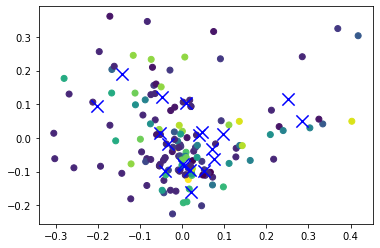

In [148]:
#Finally we can plot our results

import matplotlib.pyplot as plt
plt.scatter(reduced_features[:,0], reduced_features[:,1], c=cls.predict(features))
plt.scatter(reduced_cluster_centers[:, 0], reduced_cluster_centers[:,1], marker='x', s=150, c='b')

In [150]:
#Let's see if our clustering model did a good job, using homogenity score, 
#where a score of 1 would denote a perfect prediction and a score of 0 would be terrible
from sklearn.metrics import homogeneity_score
homogeneity_score(nodups.Company, cls.predict(features))

0.30233227609070984

In [49]:
#So, not great

#Oddly enough, if we just used reviews from companies that have greater than 5 reviews...

#filtered = nodups.loc[(nodups['Company'] == 'Lenovo') | (nodups['Company'] == 'Asus') 
#                      | (nodups['Company'] == 'HP') | (nodups['Company'] == 'Dell')
#                      | (nodups['Company'] == 'Acer') | (nodups['Company'] == 'MSI')
#                      | (nodups['Company'] == 'Toshiba')]

#(7 companies, 121 observations)

#And performed all the same calculations as above, breaking into 7 clusters, 
#we actually end up with a lower homogenity score: #0.1562330422969558

In [61]:
#Word Clouds

In [62]:
pip install wordcloud

Note: you may need to restart the kernel to use updated packages.


In [63]:
from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

In [82]:
#As an example, let's start with a Wordcloud of our Apple review
#We know this review fairly well by now, but it doesn't help to print it again here.
#As we should recall from the TF-IDF from this review, there are no repeat words

text = nodups.Reviews[0]
text

"The classic MacBook Air gets the biggest makeover in Apple's new M1 chip Mac lineup, going fanless and adding hours battery life."

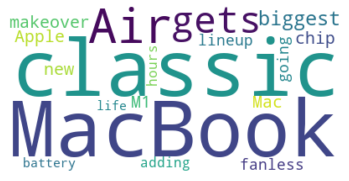

In [84]:
#There are two important defaults we should be mindful of:
#1. Since there are no repeated words, this will emphasize the MOST important words (using a ranking from a TF-IDF)
#2. This will also remove the same list of stopwords as before

wordcloud = WordCloud(background_color="white").generate(text)

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [151]:
#Out of curiosity, let's see what a WordCloud of ALL of our CNET reviews would look like
alltext = " ".join(review for review in nodups.Reviews)
print ("There are {} words in the combination of all reviews.".format(len(alltext)))

There are 20018 words in the combination of all reviews.


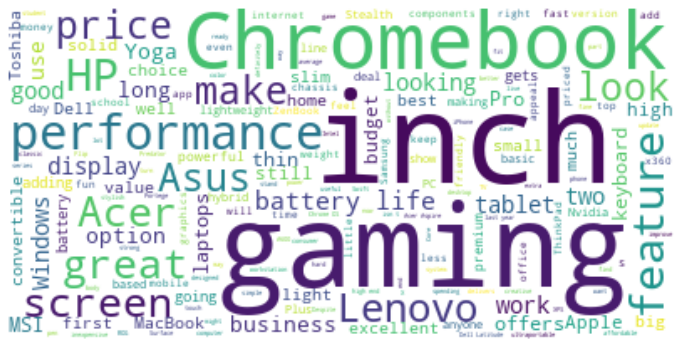

In [152]:
#The largest words here will be those most frequently used
wordcloud = WordCloud(stopwords=stopwords, background_color="white").generate(alltext)

plt.figure(figsize=(12,8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

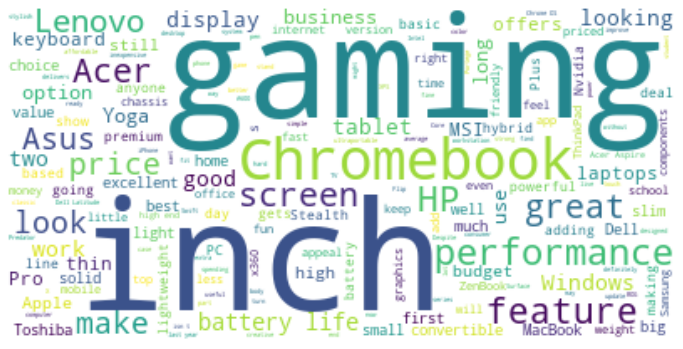

In [153]:
#We can use this WordCloud as a tool for additional processing.
#For instance, we see some words that are not that helpful:

#We can add these to our list of stop words
stopwords = set(STOPWORDS)
stopwords.update(["laptop", "one", "new", "design", "need", "offer"])

wordcloud = WordCloud(stopwords=stopwords, background_color="white").generate(alltext)

plt.figure(figsize=(12,8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [131]:
#Much more specific!
#We can fine tune our results even moreso by creating WordClouds for each company
from PIL import Image
import numpy as np
from wordcloud import ImageColorGenerator

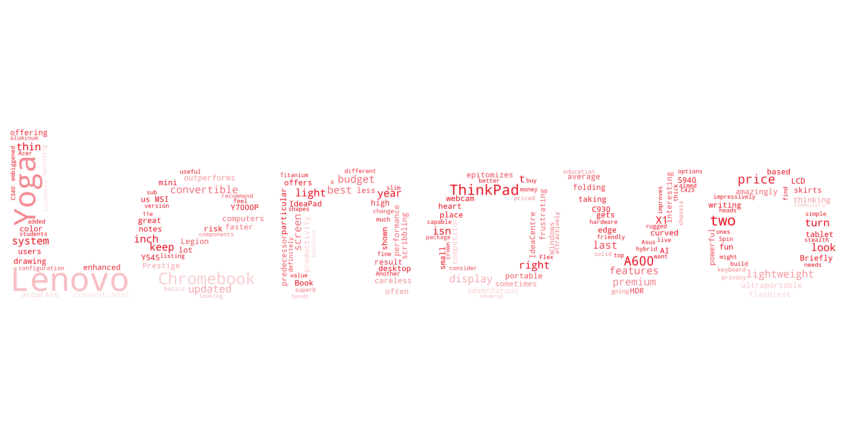

In [132]:
#Lenovo

#Filter on just Lenovo reviews
lenovo = nodups.loc[(nodups['Company'] == 'Lenovo')]
lenovo_reviews = " ".join(review for review in lenovo.Reviews)

#Create Lenovo WordCloud in a fun shape
mask = np.array(Image.open('C:/Users/bryan/Desktop/Mining/FINAL/Lenovo.jpg'))
mask_colors = ImageColorGenerator(mask)

wc = WordCloud(stopwords=stopwords,
               mask=mask, background_color="white",
               max_words=2000, max_font_size=256,
               random_state=42, width=mask.shape[1],
               height=mask.shape[0], color_func=mask_colors)
wc.generate(lenovo_reviews)

plt.figure(figsize=(15,10))
plt.imshow(wc, interpolation="bilinear")
plt.axis('off')
plt.show()

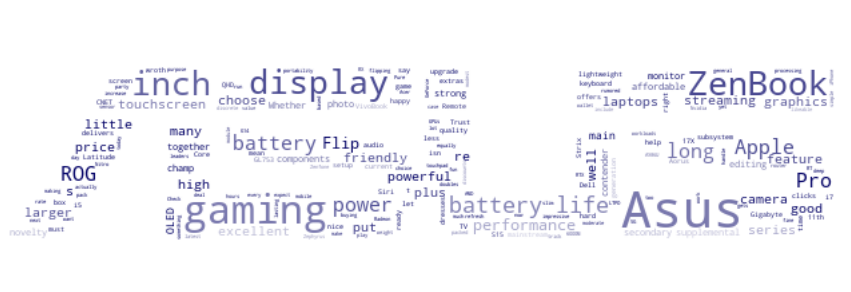

In [135]:
#Asus

asus = nodups.loc[(nodups['Company'] == 'Asus')]
asus_reviews = " ".join(review for review in asus.Reviews)

mask = np.array(Image.open('C:/Users/bryan/Desktop/Mining/FINAL/Asus.jpg'))

mask_colors = ImageColorGenerator(mask)

wc = WordCloud(stopwords=stopwords,
               mask=mask, background_color="white",
               max_words=2000, max_font_size=256,
               random_state=42, width=mask.shape[1],
               height=mask.shape[0], color_func=mask_colors)

wc.generate(asus_reviews)

plt.figure(figsize=(15,10))
plt.imshow(wc, interpolation="bilinear")
plt.axis('off')
plt.show()

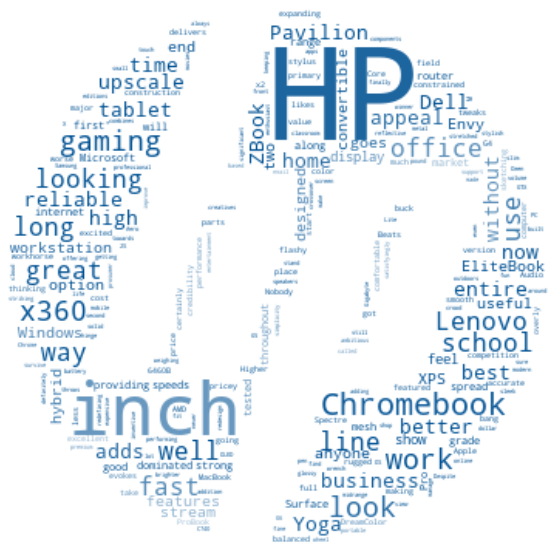

In [143]:
#HP

hp = nodups.loc[(nodups['Company'] == 'HP')]
hp_reviews = " ".join(review for review in hp.Reviews)

#Create Asus WordCloud in a fun shape

mask = np.array(Image.open('C:/Users/bryan/Desktop/Mining/FINAL/Hp.jpg'))

mask_colors = ImageColorGenerator(mask)

wc = WordCloud(stopwords=stopwords,
               mask=mask, background_color="white",
               max_words=2000, max_font_size=256,
               random_state=42, width=mask.shape[1],
               height=mask.shape[0], color_func=mask_colors)

wc.generate(hp_reviews)

plt.figure(figsize=(15,10))
plt.imshow(wc, interpolation="bilinear")
plt.axis('off')
plt.show()

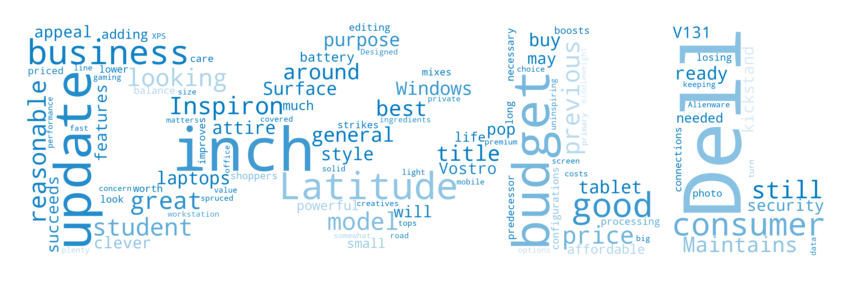

In [136]:
#Dell

dell = nodups.loc[(nodups['Company'] == 'Dell')]
dell_reviews = " ".join(review for review in dell.Reviews)

mask = np.array(Image.open('C:/Users/bryan/Desktop/Mining/FINAL/Dell.jpg'))

mask_colors = ImageColorGenerator(mask)

wc = WordCloud(stopwords=stopwords,
               mask=mask, background_color="white",
               max_words=2000, max_font_size=256,
               random_state=42, width=mask.shape[1],
               height=mask.shape[0], color_func=mask_colors)

wc.generate(dell_reviews)

plt.figure(figsize=(15,10))
plt.imshow(wc, interpolation="bilinear")
plt.axis('off')
plt.show()

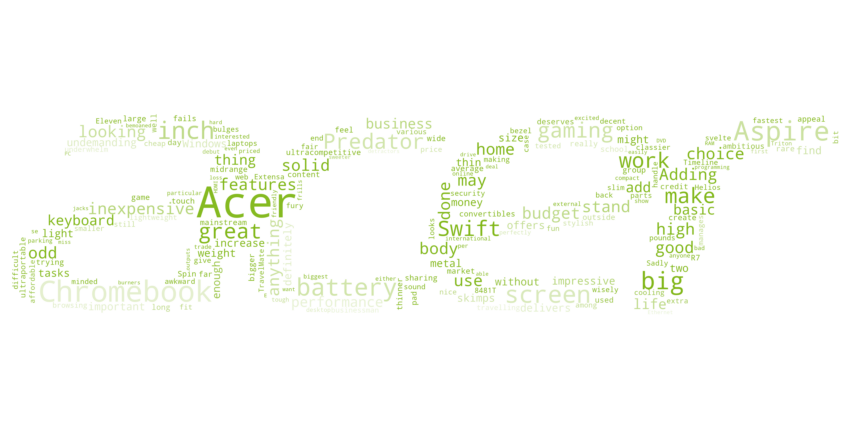

In [134]:
#Acer

acer = nodups.loc[(nodups['Company'] == 'Acer')]
acer_reviews = " ".join(review for review in acer.Reviews)

mask = np.array(Image.open('C:/Users/bryan/Desktop/Mining/FINAL/Acer.jpg'))

mask_colors = ImageColorGenerator(mask)

wc = WordCloud(stopwords=stopwords,
               mask=mask, background_color="white",
               max_words=2000, max_font_size=256,
               random_state=42, width=mask.shape[1],
               height=mask.shape[0], color_func=mask_colors)

wc.generate(acer_reviews)

plt.figure(figsize=(15,10))
plt.imshow(wc, interpolation="bilinear")
plt.axis('off')
plt.show()

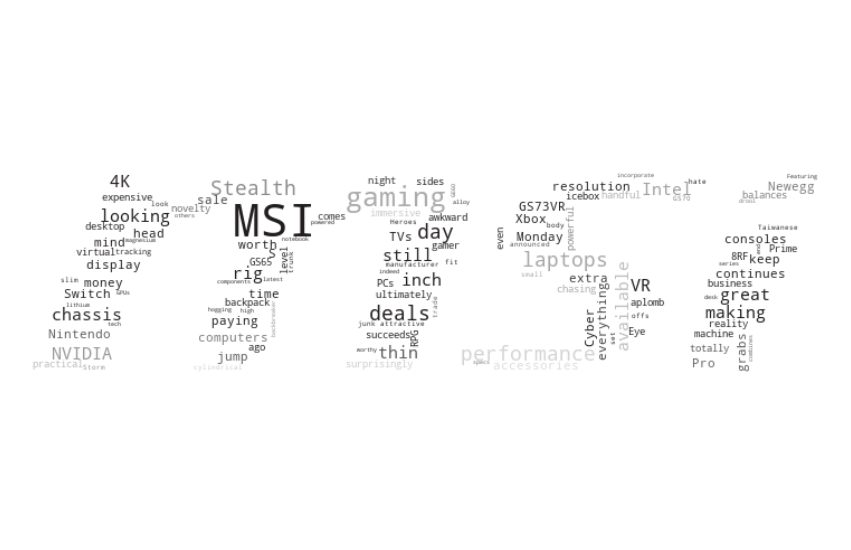

In [133]:
#MSI

msi = nodups.loc[(nodups['Company'] == 'MSI')]
msi_reviews = " ".join(review for review in msi.Reviews)

#Create Asus WordCloud in a fun shape

mask = np.array(Image.open('C:/Users/bryan/Desktop/Mining/FINAL/Msi.jpg'))

mask_colors = ImageColorGenerator(mask)

wc = WordCloud(stopwords=stopwords,
               mask=mask, background_color="white",
               max_words=2000, max_font_size=256,
               random_state=42, width=mask.shape[1],
               height=mask.shape[0], color_func=mask_colors)

wc.generate(msi_reviews)

plt.figure(figsize=(15,10))
plt.imshow(wc, interpolation="bilinear")
plt.axis('off')
plt.show()

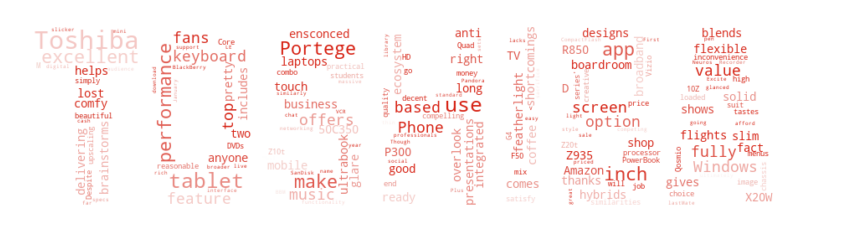

In [130]:
#Toshiba

toshiba = nodups.loc[(nodups['Company'] == 'Toshiba')]
toshiba_reviews = " ".join(review for review in toshiba.Reviews)

#Create Asus WordCloud in a fun shape

mask = np.array(Image.open('C:/Users/bryan/Desktop/Mining/FINAL/Toshiba.jpg'))

mask_colors = ImageColorGenerator(mask)

wc = WordCloud(stopwords=stopwords,
               mask=mask, background_color="white",
               max_words=2000, max_font_size=256,
               random_state=42, width=mask.shape[1],
               height=mask.shape[0], color_func=mask_colors)

wc.generate(toshiba_reviews)

plt.figure(figsize=(15,10))
plt.imshow(wc, interpolation="bilinear")
plt.axis('off')
plt.show()